In [ ]:
!pip install wfdb

In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.5 MB/s eta 0:00:00


In [ ]:

!pip -q install wfdb imbalanced-learn

import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    project_directory = '/content/drive/MyDrive/TinyML/'  # Change this path to match your Google Drive directory
    os.chdir(project_directory)
except:
    pass


Mounted at /content/drive


In [ ]:
RECORDS = r"/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/RECORDS"
patient_ids = pd.read_csv(RECORDS, header=None, engine="python").to_numpy().reshape(-1)
patient_ids


array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234])

In [ ]:
DATA_ROOT = r"/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/"

In [ ]:
#Extracting just 1 patient ECG signal and info
lead0 = {}  # without this it shows lead0[100] is not defined
lead1 = {}
patient_id = 100
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(100)))
lead0[100] = signals[:, 0]
lead1[100] = signals[:, 1]

In [ ]:
# Loading all patients ECG SIGNALs using for loop
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
        print(f'Signal of patient {id_} extracted')
    return lead0, lead1

In [ ]:
# Loading all patient ECG INFORMATION
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_ids)))
    resolution = 2**11  # Number of possible signal values we can have.
    info["resolution"] = 2**11
    return info

In [ ]:
lead0, lead1 = get_ecg_signals(patient_ids)

Signal of patient 100 extracted
Signal of patient 101 extracted
Signal of patient 102 extracted
Signal of patient 103 extracted
Signal of patient 104 extracted
Signal of patient 105 extracted
Signal of patient 106 extracted
Signal of patient 107 extracted
Signal of patient 108 extracted
Signal of patient 109 extracted
Signal of patient 111 extracted
Signal of patient 112 extracted
Signal of patient 113 extracted
Signal of patient 114 extracted
Signal of patient 115 extracted
Signal of patient 116 extracted
Signal of patient 117 extracted
Signal of patient 118 extracted
Signal of patient 119 extracted
Signal of patient 121 extracted
Signal of patient 122 extracted
Signal of patient 123 extracted
Signal of patient 124 extracted
Signal of patient 200 extracted
Signal of patient 201 extracted
Signal of patient 202 extracted
Signal of patient 203 extracted
Signal of patient 205 extracted
Signal of patient 207 extracted
Signal of patient 208 extracted
Signal of patient 209 extracted
Signal o

In [ ]:
# Plot any patient signal from any time frame
patient_id = 100 # can change
starting_time = 0 # can change
ending_time = 10 # can change

# Scaling
starting_signal_point = starting_time*350
ending_signal_point = ending_time*350 # As sampling frequency is 350 Hz
x = np.arange(starting_time, ending_time, 1/350)
signal = lead0[patient_id][starting_signal_point: ending_signal_point]

In [ ]:
# ECG info of any patient
ecg_info = get_ecg_info(patient_ids[0])
ecg_info

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'resolution': 2048}

In [ ]:
project_path = r"/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/"

In [ ]:
# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [ ]:
# Plotting a signal before denoising
record = wfdb.rdrecord(project_path + '100', channel_names=['MLII'])
data = record.p_signal.flatten()

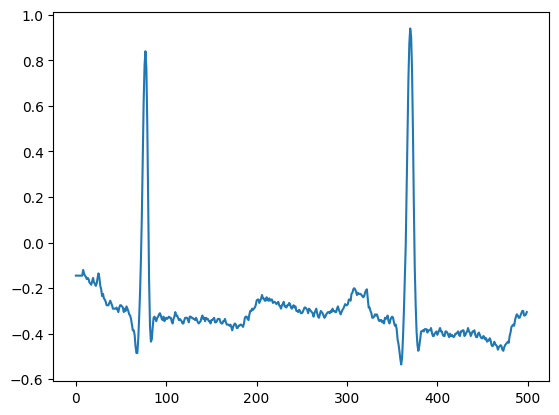

In [ ]:
# Ploting a signal before denoising
record = wfdb.rdrecord(project_path + '100', channel_names=['MLII'])
data = record.p_signal.flatten()
plt.plot(data[0:500])

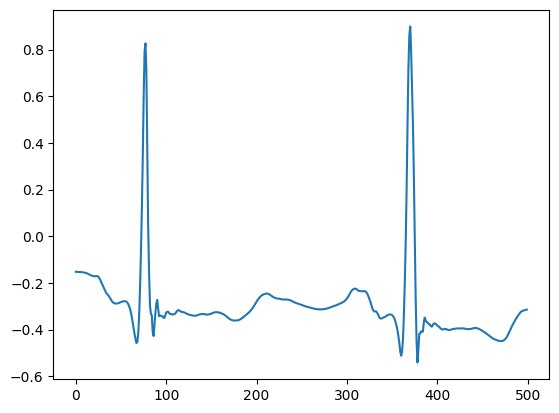

In [ ]:
# Same signal after denoising
rdata = denoise(data=data)
plt.plot(rdata[0:500])

In [ ]:
# For exmaple, we extract '100' recording annotation
annotation = wfdb.rdann(project_path + '100', 'atr')
Rlocation = annotation.sample
print(Rlocation)
Rclass = annotation.symbol
print(Rclass)

[    18     77    370 ... 649484 649734 649991]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

In [ ]:
len(annotation.symbol)

2274

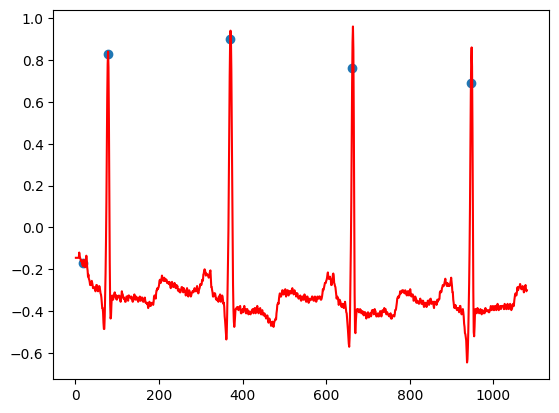

In [ ]:
# R-peak ploting
x = np.arange(1, 1081)

n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])

plt.plot(x, data[0:1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

(300,)
(300,)
(300,)


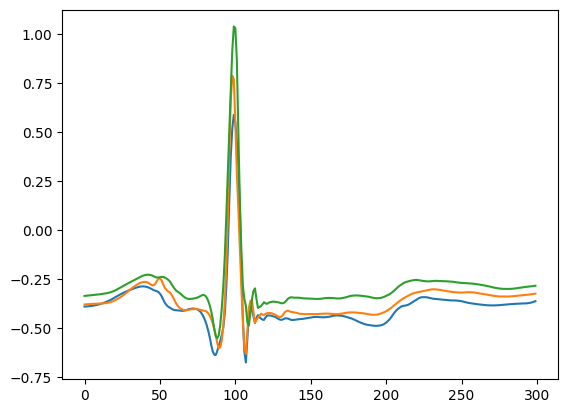

In [ ]:
# Plotting 3 heartbeats
k = np.arange(100, 103)
for i in k:
  # print(i)
  # print(Rlocation[i] - 99, Rlocation[i] + 201)
  x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
  plt.plot(x_train)
  print(x_train.shape)
plt.show()

In [ ]:
r_peak_xx = Rlocation[0], Rlocation[1], Rlocation[2], Rlocation[3]
r_peak_yy = rdata[Rlocation[0]], rdata[Rlocation[1]], rdata[Rlocation[2]], rdata[Rlocation[3]]

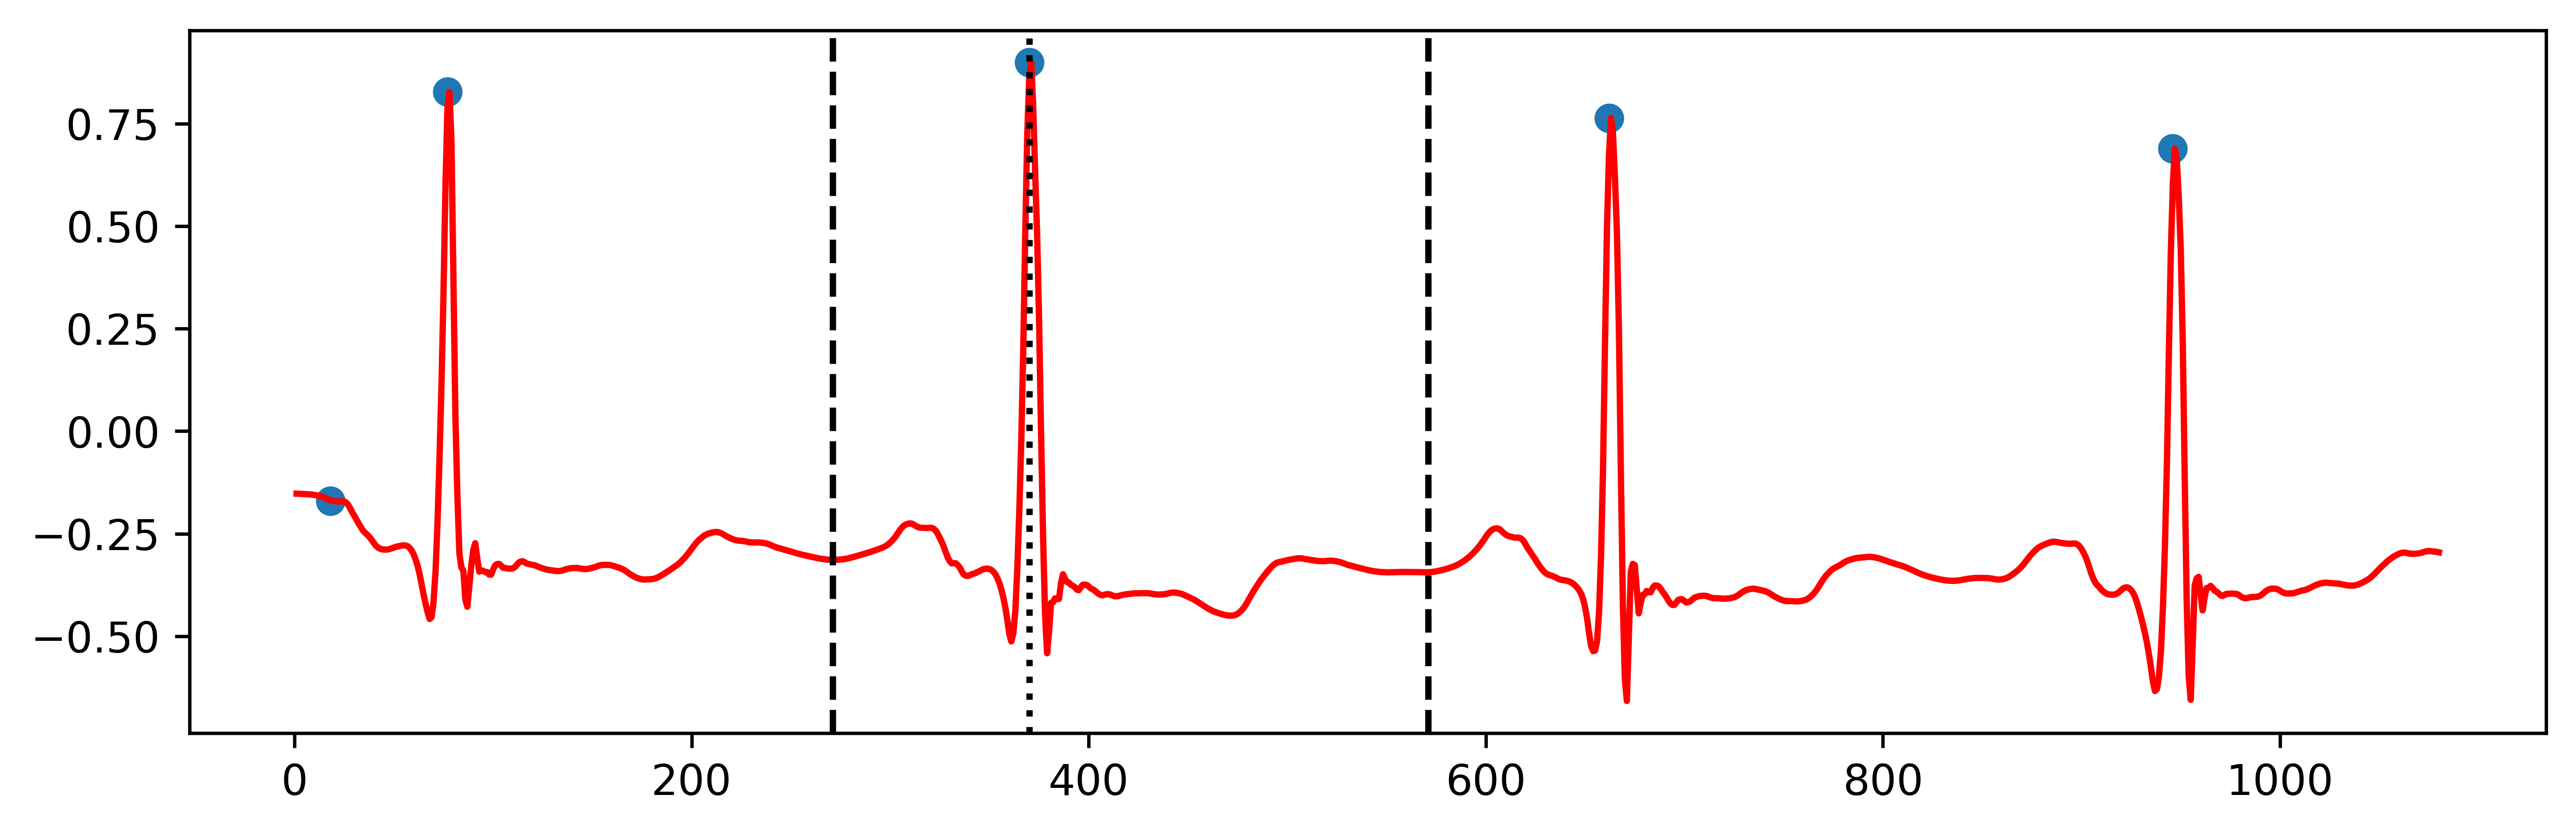

In [ ]:
# Plotting R-peaks and segmentation lines
fig = plt.figure(figsize=(10,3), dpi=600)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':')
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--')

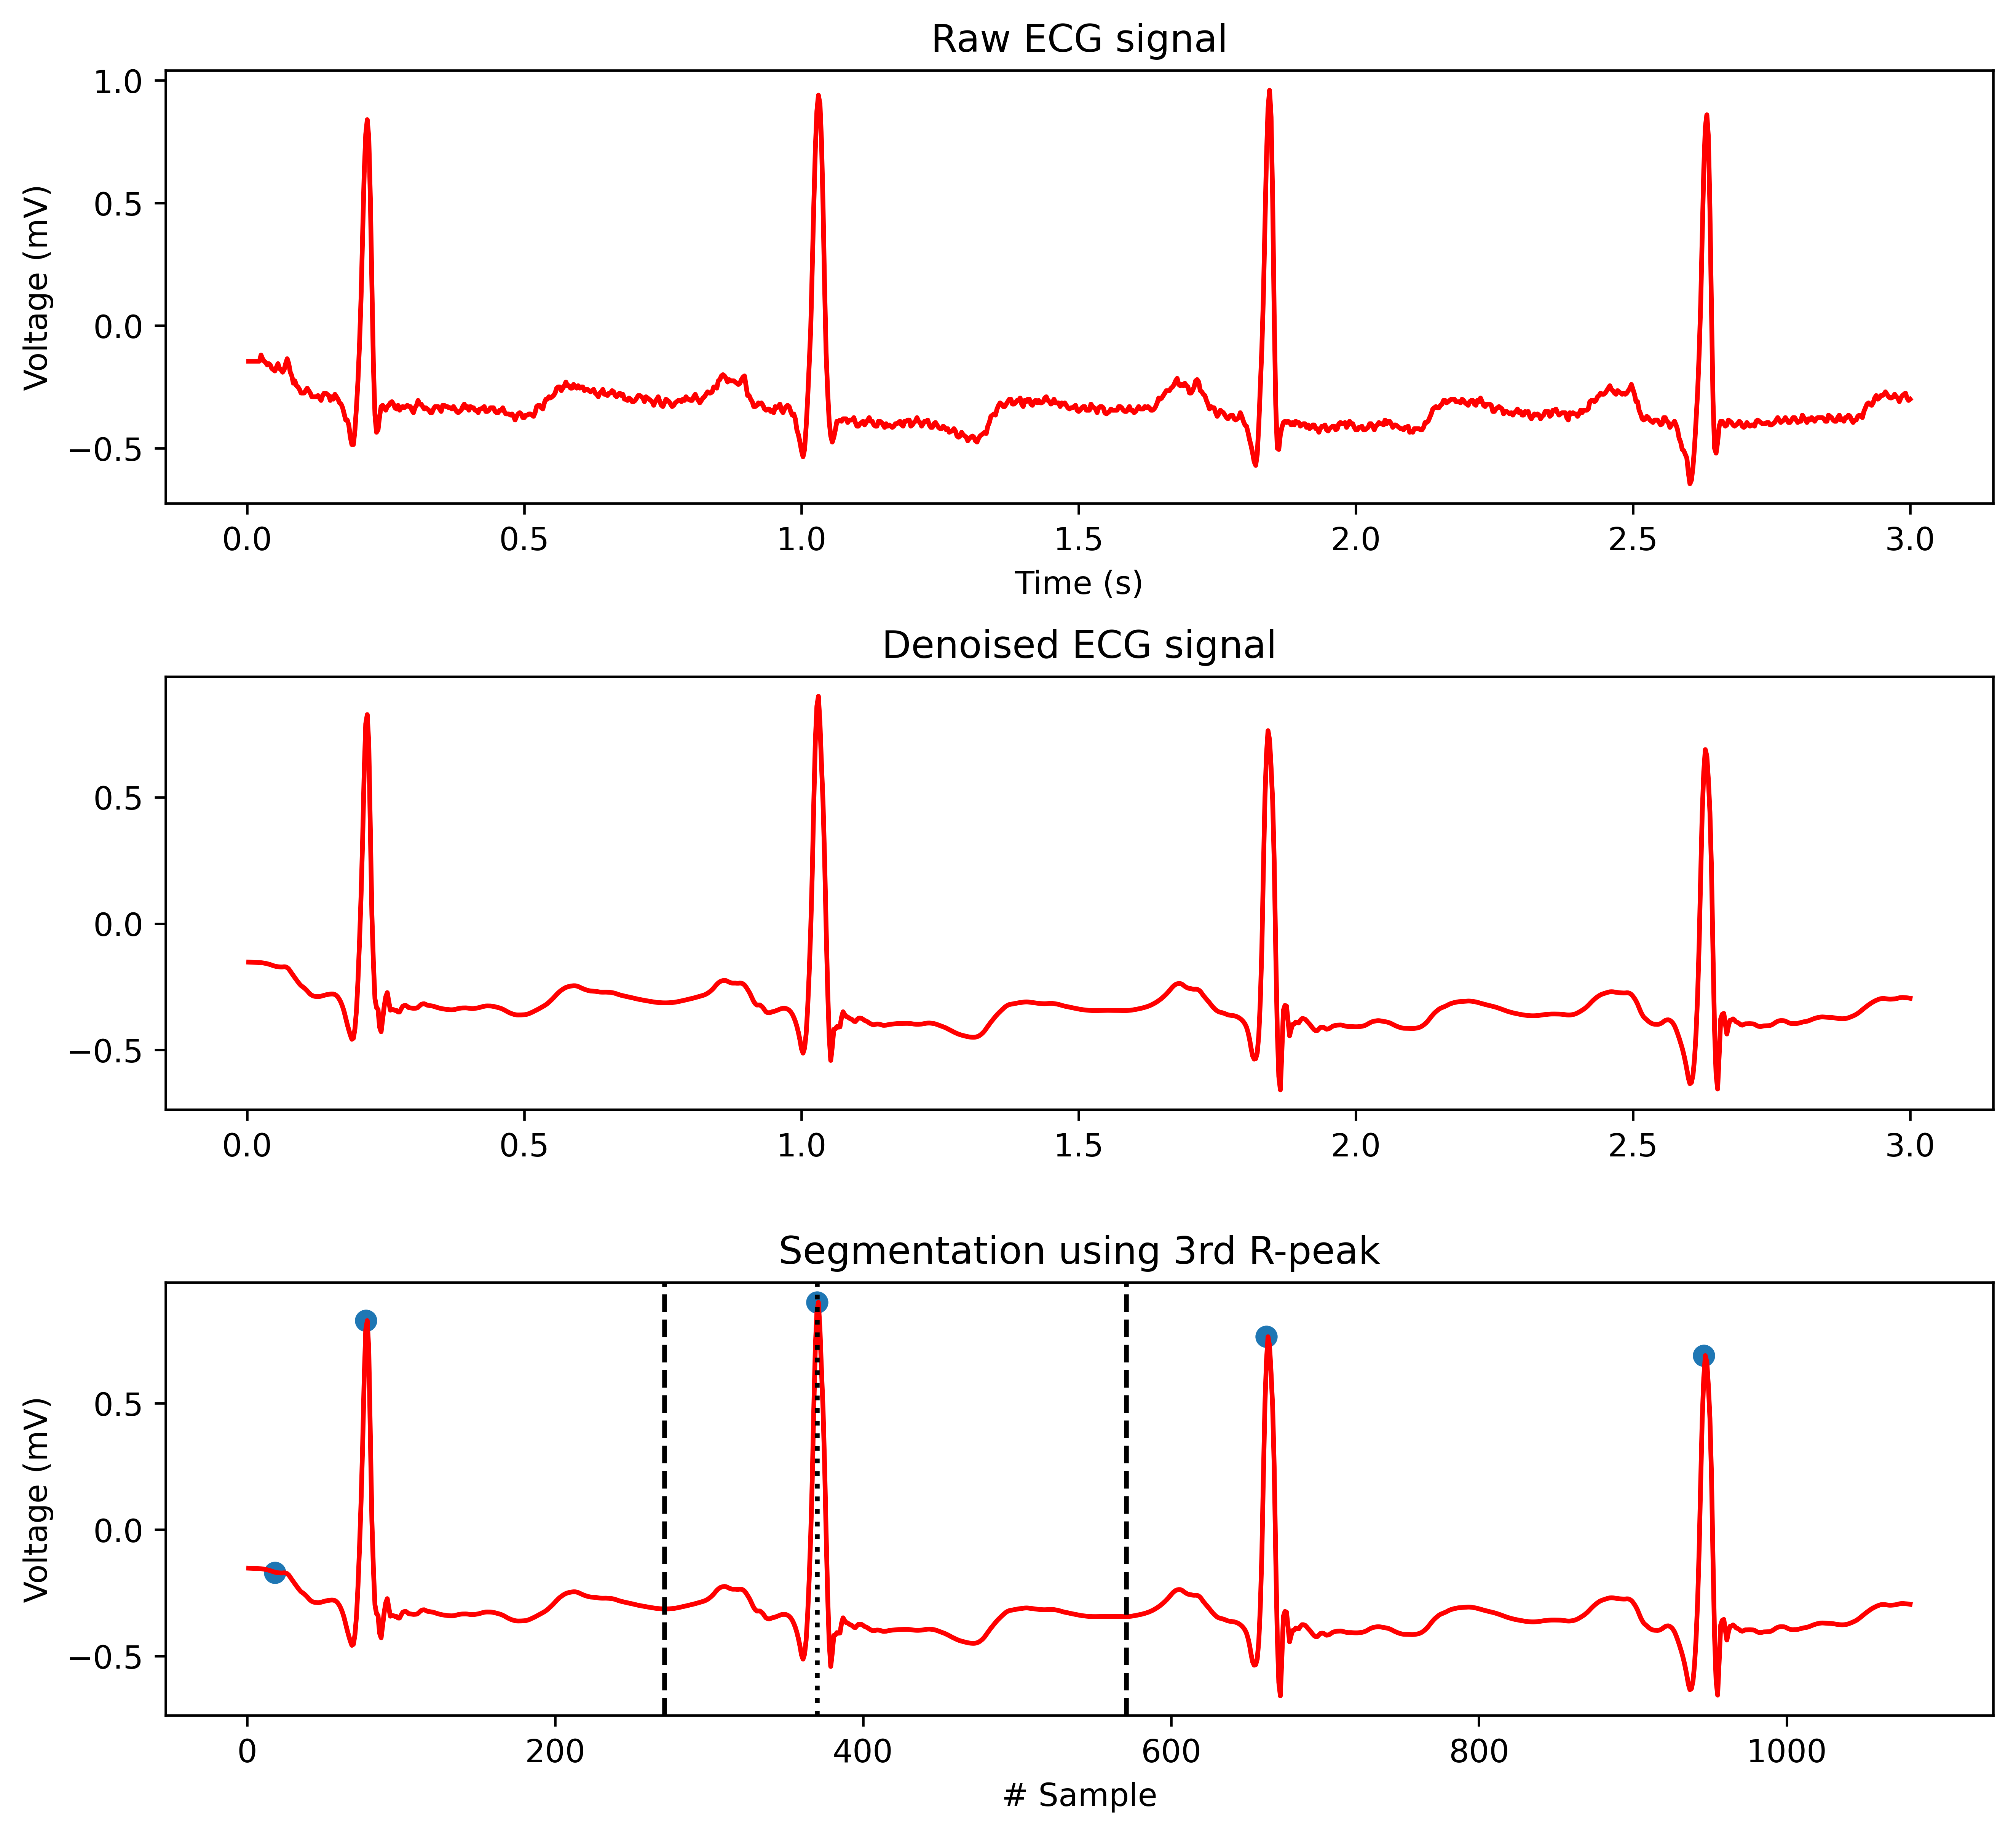

In [ ]:
# Plot together raw, denoised and segmted signal
fig = plt.figure(figsize=(10,9), dpi=600)
x = np.arange(1, 1081)

# Raw signal plotting
plt.subplot(3, 1, 1)
plt.plot(x/360, data[0:1080], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG signal')

# Denoised signal plotting
plt.subplot(3, 1, 2)
plt.plot(x/360, rdata[0:1080], color='red')
plt.title('Denoised ECG signal')

# Segmentation visualization using two border lines
plt.subplot(3, 1, 3)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)
# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') # 3rd r-peak
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--')

plt.xlabel('# Sample')
plt.ylabel('Voltage (mV)')
plt.title('Segmentation using 3rd R-peak')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

figure_path = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\heartbeat_figures\\'
fig.savefig(figure_path+ 'Denoised and segmented ECG.png')

DATASET LOADING


In [ ]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(project_path, number))
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(project_path + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(project_path + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [ ]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

In [ ]:
# Input X and Output Y data loading
X, Y = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [ ]:
from collections import Counter

In [ ]:
# Counting the number of each type of heartbeats
Y_list = list(Y)
Counter(Y_list)

Counter({0.0: 74920,
         2.0: 7244,
         5.0: 2540,
         12.0: 7012,
         1.0: 8063,
         9.0: 7123,
         7.0: 83,
         4.0: 229,
         3.0: 16,
         11.0: 802,
         13.0: 982,
         6.0: 150,
         10.0: 106,
         14.0: 33,
         8.0: 2})

In [ ]:
# making pandas dataframe
df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y)

In [ ]:
# changing the name from 0 to 300
df_Y.rename(columns = {0:300}, inplace = True)
# join X and Y
df = pd.concat([df_X, df_Y], axis=1)

In [ ]:
def Plot_Random_Beat(type, num):

  ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', 'slash', 'f', 'Q']

  ecgClassName = ['Normal (N)', 'Left bundle br. bl. (L)', 'Right bundle br. bl. (R)',
                  'Atrial escape (e)', 'Nodal jun. esc. (j)', 'Atrial premature (A)',
                  'Aberrated atrial prem. (a)', 'Nodal jun. pre. (J)',
                  'Supraventricular prem. (S)', 'Premature ventr. (V)',
                  'Ventricular escape (E)', 'Fusion of ve. & no. (F)',
                  'Paced (/)', 'Fusion of pa. & no. (f)',
                  'Unclassifiable(Q)']

  # getting only a specific class ECG signal
  df_0 = df.loc[df[300]==type]  # For normanl class: 0, shape is 74920,301
  df_0 = df_0.drop(columns=[300]) # changing the shape to 74920,300

  # selecting some random row to plot
  if num<=df_0.shape[0]:
    np.random.seed(234)
    random_beat_number = np.random.randint(df_0.shape[0], size=(num))
    random_beat_number = list(random_beat_number)
  else: # Needed for Supraventricular Premature Beat (S) only, as it contains only 2 beats
    print(f"Warning: You have only {df_0.shape[0]} beat, but asked to plot {num}")
    random_beat_number = np.arange(0, df_0.shape[0])
    random_beat_number = list(random_beat_number)

  # ploting the ECG signal
  for i in random_beat_number:
    ecg_beat = df_0.iloc[i]
    plt.plot(ecg_beat)
  plt.title(str(ecgClassName[type]))

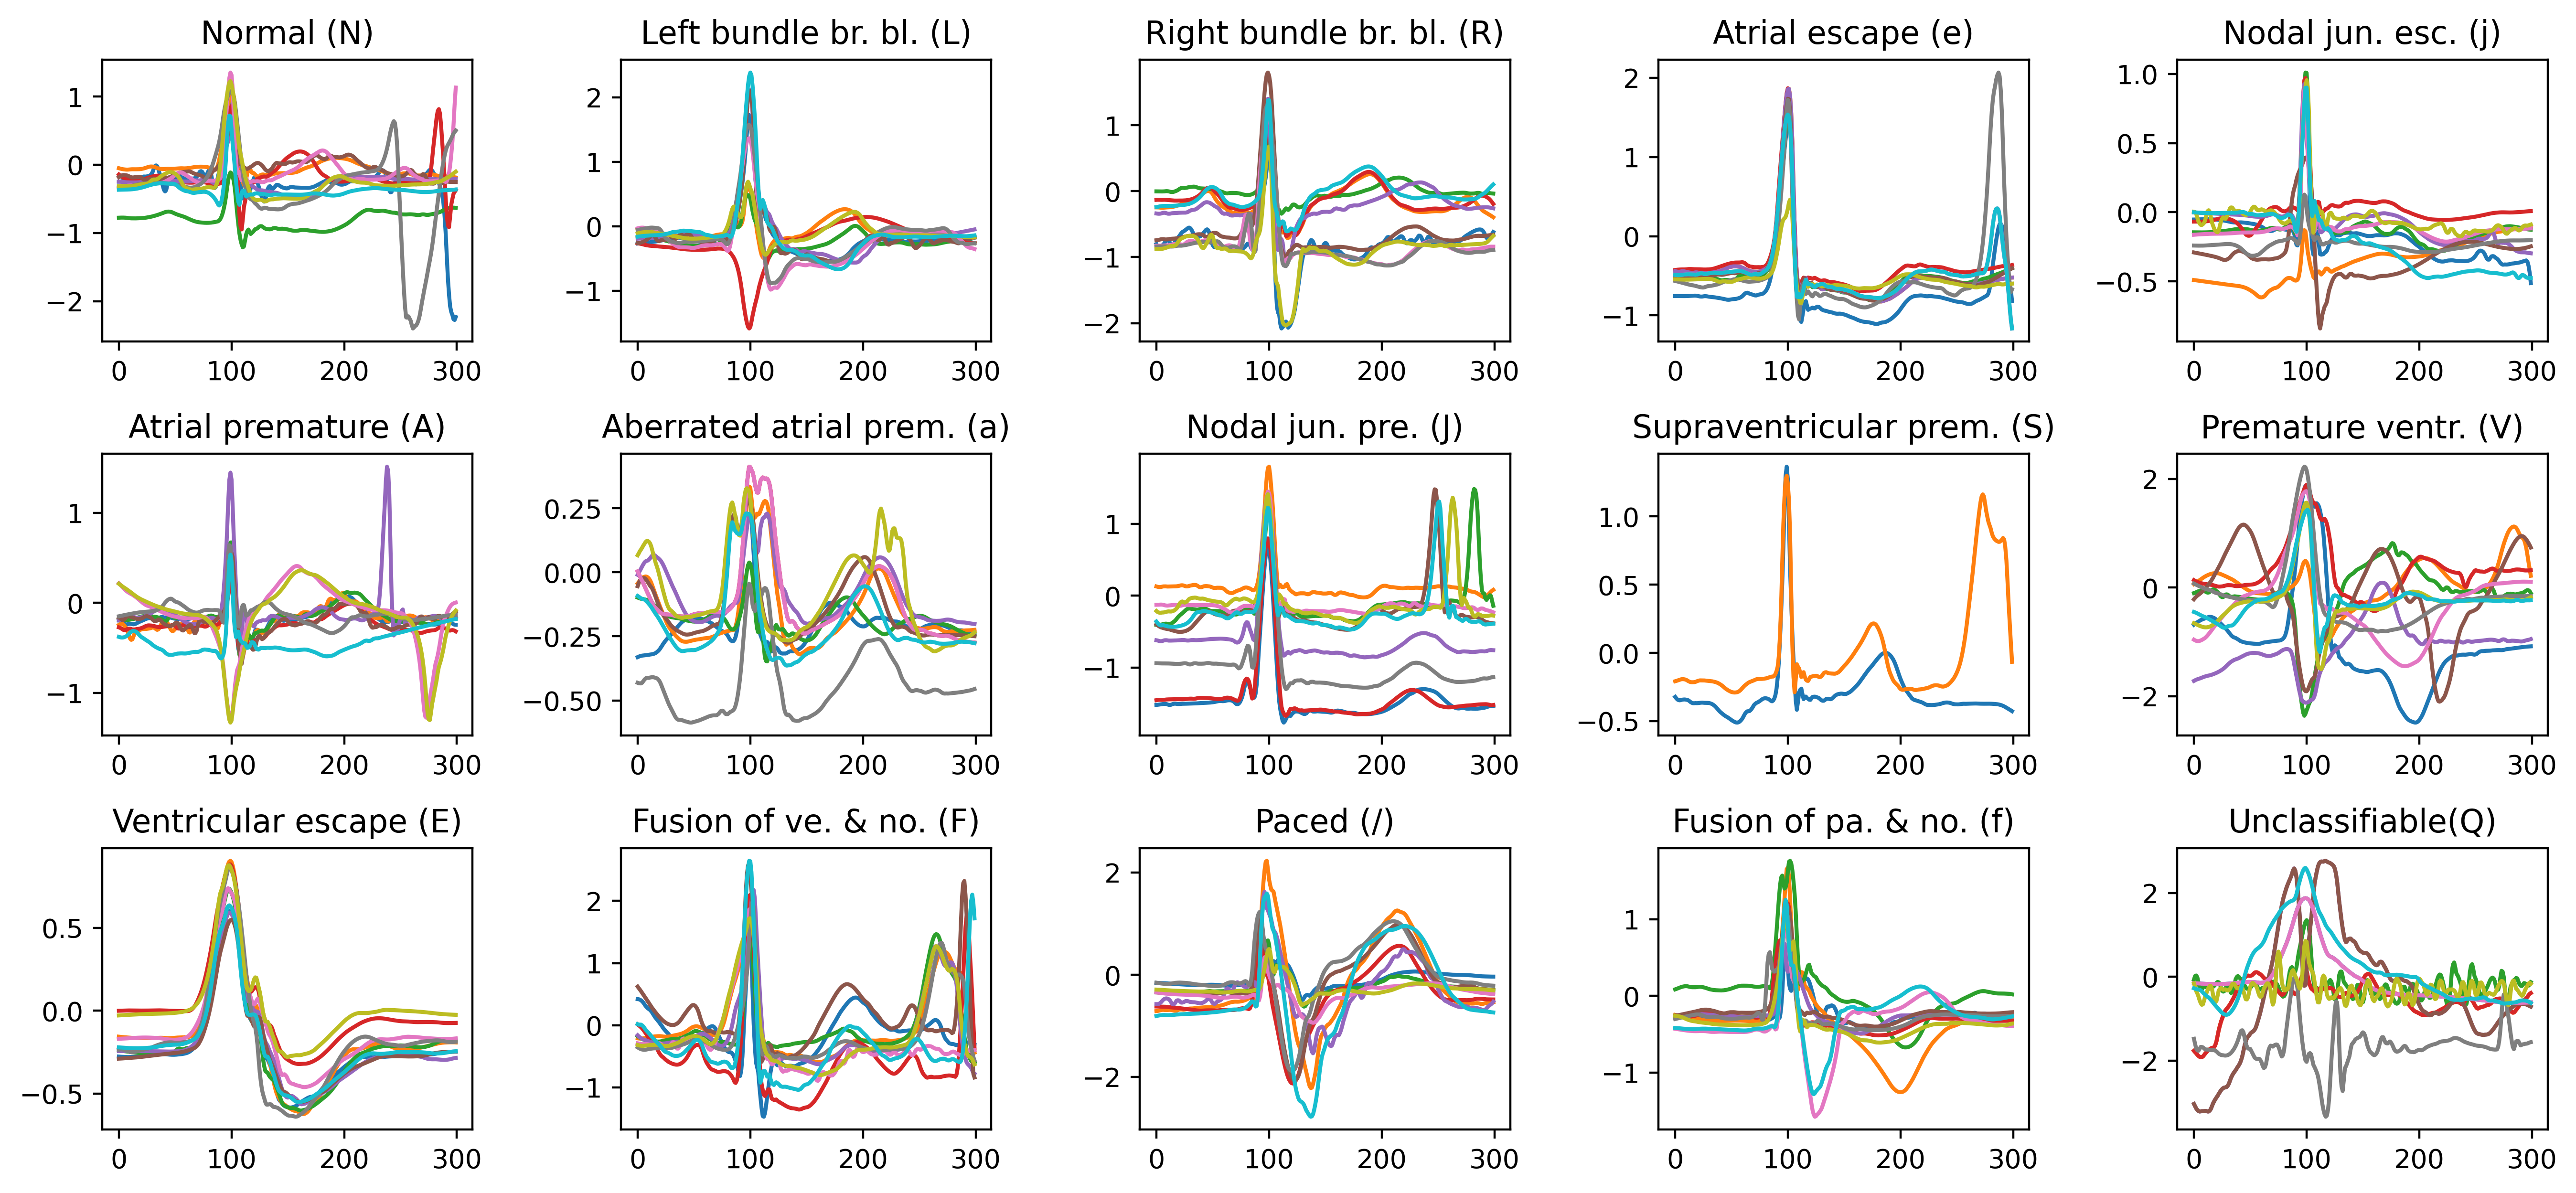

In [ ]:
# Plotting 15 different types of heartbeat
fig = plt.figure(figsize=(16,7), dpi=400)
fig.tight_layout(pad=15.0)
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
  Plot_Random_Beat(type=i, num=10)
figure_path = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\heartbeat_figures\\'
fig.savefig(figure_path+ 'all_heartbeats.png')

TRAIN-TEST SPLIT + CLASS BALANCE

In [ ]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [ ]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300
# and 301 colum is its label among 15 difference level
train_ds = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [ ]:
Y = train_ds[:, 300]

In [ ]:
# Here 15 class of ECG data are saved
Y_list = list(Y)
Counter(Y_list)

Counter({2.0: 7244,
         0.0: 74920,
         13.0: 982,
         12.0: 7012,
         9.0: 7123,
         1.0: 8063,
         5.0: 2540,
         11.0: 802,
         6.0: 150,
         10.0: 106,
         4.0: 229,
         3.0: 16,
         7.0: 83,
         14.0: 33,
         8.0: 2})

In [ ]:
# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

changing done


In [ ]:
# the original Y labels with 15 different classes are being converted into 5 broader classes and stored in Y_5class.
# This reduction simplifies the classification by grouping specific classes together based on certain characteristics,
# likely related to similarity in heartbeat types.

In [ ]:
Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

Counter({0.0: 90472, 4.0: 8027, 2.0: 7229, 1.0: 2775, 3.0: 802})

In [ ]:
ecg_dataset = np.copy(train_ds)

In [ ]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

In [ ]:
ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work

In [ ]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

In [ ]:
# Convert ndarray to dataframe
df_ecg = pd.DataFrame(ecg_dataset_5)
class_data = df_ecg[300].value_counts()
class_data

300
0.0    90472
4.0     8027
2.0     7229
1.0     2775
3.0      802
Name: count, dtype: int64

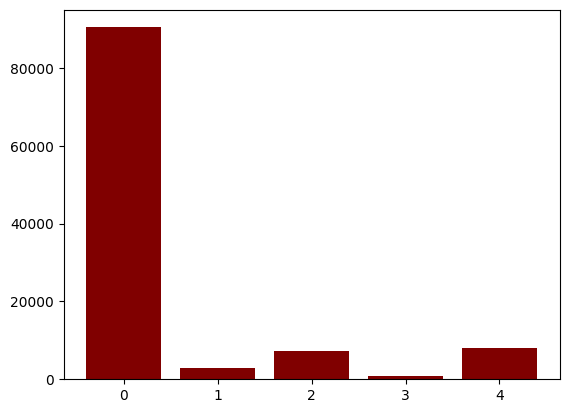

In [ ]:
# per class data status plotting,
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

<Axes: xlabel='300'>

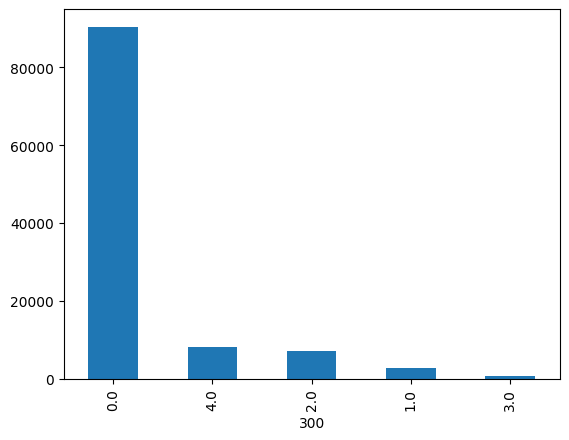

In [ ]:
# shortcut for per class data status plotting,
# Order is not maintained by class. Higher to lower
df_ecg[300].value_counts().plot(kind='bar')

In [ ]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

In [ ]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [ ]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [ ]:
# saving the test data (in imbalanced condition)
file_name = project_path + 'test_data.pkl'
test_data.to_pickle(file_name)

300
0.0    72396
4.0     6421
2.0     5773
1.0     2223
3.0      631
Name: count, dtype: int64


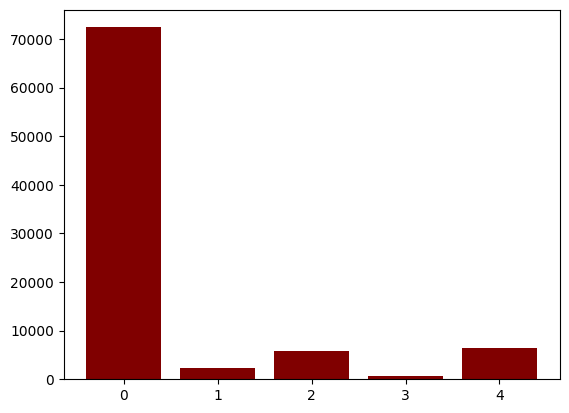

In [ ]:
# Imblanced training data graph ploting
class_data = train_data[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

In [ ]:
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

In [ ]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [ ]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:50000, 2:50000, 3:50000, 4:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

In [ ]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[-0.28722445, -0.28848494, -0.28968116, ..., -0.2676001 ,
        -0.27120236,  0.        ],
       [-0.30751179, -0.3057489 , -0.30397116, ...,  0.75158413,
         0.82591842,  0.        ],
       [-0.16800687, -0.17244045, -0.17732933, ..., -0.28988055,
        -0.28821461,  1.        ],
       ...,
       [-0.07768788, -0.0759095 , -0.07457754, ..., -0.13804258,
        -0.13573806,  0.        ],
       [-0.65170895, -0.66662218, -0.68198135, ..., -0.11181153,
        -0.0988044 ,  2.        ],
       [ 0.0824179 ,  0.05861659,  0.0314233 , ...,  1.74909868,
         1.61083942,  2.        ]])

300
0.0    50000
1.0    50000
2.0    50000
3.0    50000
4.0    50000
Name: count, dtype: int64


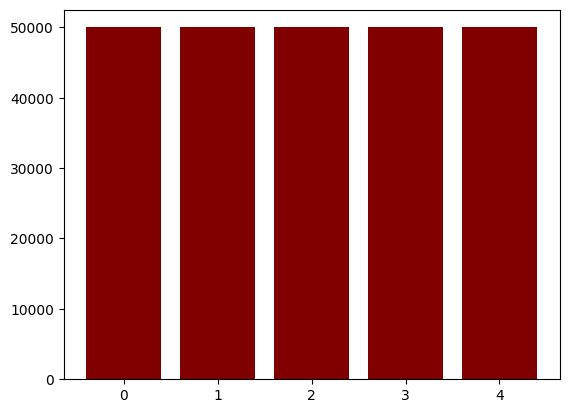

In [ ]:
# blanced training data graph ploting
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

# save balanced training data
file_name = project_path + 'train_data_SMOTE.pkl'
train_data_r.to_pickle(file_name)

In [ ]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)

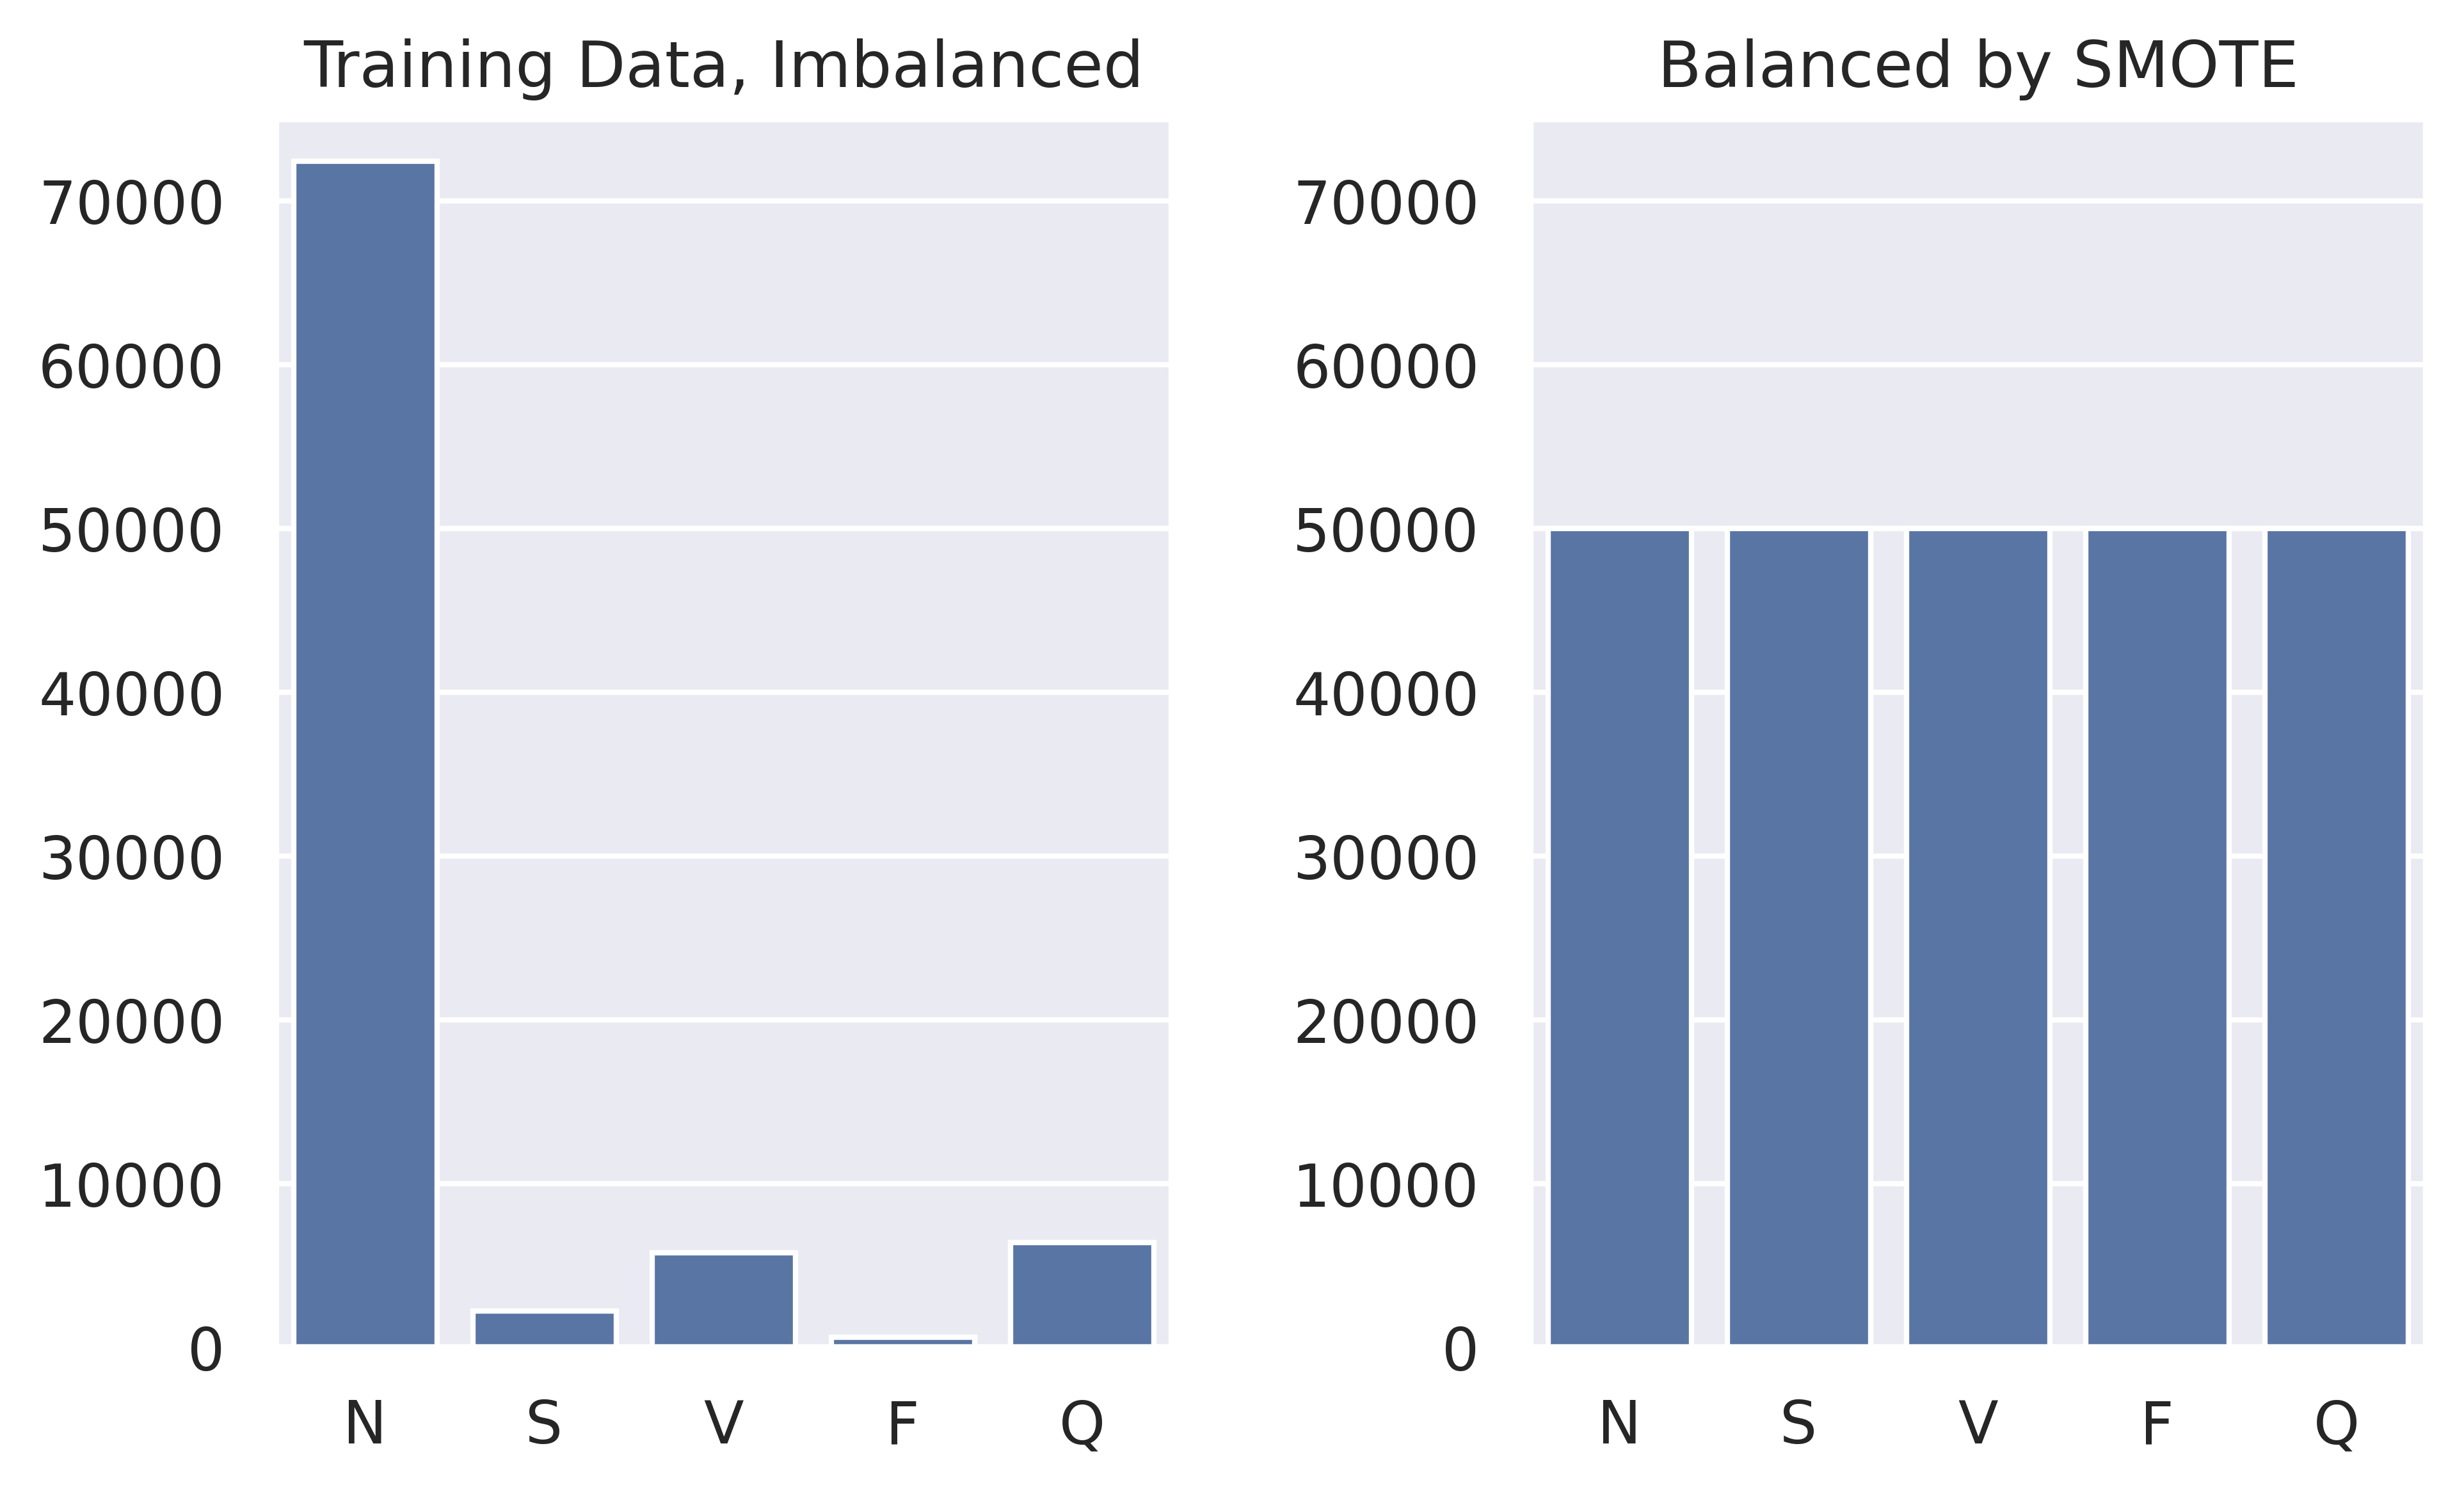

In [ ]:
# a single plot which gives proper illustration before and after class balancing
import seaborn as sns
sns.set()
sns.color_palette("hls", 8)

fig = plt.figure(figsize=(7,4), dpi=600)
plt.subplot(121)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = [72420, 2212, 5774, 637, 6401])
plt.ylim(0, 75000)
plt.title('Training Data, Imbalanced')

plt.subplot(122)
sns.barplot(x = ['N', 'S', 'V', 'F', 'Q'], y = class_data.values)
plt.ylim(0, 75000)
plt.title('Balanced by SMOTE')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

figure_path = r'D:\endyrproj\arry_svn\Arrhythmia_Classification-main\heartbeat_figures\\'
fig.savefig(figure_path+ 'Class balancing.png')

MODEL BUILDING AND TRAINING


In [ ]:
# udf for channel attention mechanism
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [ ]:
# udf for spatial attention mechanism
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [ ]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, sixteen 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(16, 8),
        # SpatialAttention(7),
        # The first pooling layer, max pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The second convolution layer, 32 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(32, 8),
        # SpatialAttention(7),
        # The second pooling layer, max pooling, 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # The third convolution layer, 64 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(64, 8),
        # SpatialAttention(7),
        # The third pooling layer, average pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # The fourth convolution layer, 128 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        ChannelAttention(128, 8),
        SpatialAttention(7),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 32 nodes
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

In [ ]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # The first convolutional layer, four 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='same', activation='relu'),
        # The first pooling layer, max pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The second convolution layer, 16 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='same', activation='relu'),
        # The second pooling layer, max pooling, four 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The third convolution layer, 32 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='same', activation='relu'),
        # The third pooling layer, average pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='same'),
        # The fourth convolution layer, 64 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='same', activation='relu'),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(128, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

In [ ]:
project_path

'/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/'

In [ ]:
#Define the log directory, which must be a subdirectory of the specified
#directory when starting the web application. It is recommended to use date and time as the subdirectory name
logdir = project_path + "logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = project_path + "ecg_model_code 17_t5.h5"

In [ ]:
# percentage of training data used for model validation
ratio = 0.2

In [ ]:
if os.path.exists(model_path):
  # Import the trained model
  print('Model is already have in the filepath')
  model = tf.keras.models.load_model(filepath=model_path)
else:
  # Build a CNN model
  print('Model not found, now building and then saving')
  model = buildModel()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  # Define the TensorBoard object
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
  # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
  checkpoint_filepath=project_path + "code_17_t5_weights.weights.h5"
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                 save_weights_only=True, monitor='val_accuracy',
                                                                 mode='max', save_best_only=True)
  callback_list = [tensorboard_callback, model_checkpoint_callback]
  # Training and Validation
  history = model.fit(x_train, y_train, epochs=30,
            batch_size=128,
            validation_split=ratio,
            callbacks=callback_list)
  model.save(filepath=model_path)

Model not found, now building and then saving


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 300, 16)             │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 150, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 150, 32)             │          11,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 75, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 75, 64)              │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 38, 128)             │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 38, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 38, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2432)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         311,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 777,797 (2.97 MB)

 Trainable params: 777,797 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 399s 715ms/step - accuracy: 0.8972 - loss: 0.3789 - val_accuracy: 0.9718 - val_loss: 0.1176
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 422s 679ms/step - accuracy: 0.9728 - loss: 0.1031 - val_accuracy: 0.9759 - val_loss: 0.0875
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 381s 677ms/step - accuracy: 0.9810 - loss: 0.0682 - val_accuracy: 0.9851 - val_loss: 0.0546
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 372s 680ms/step - accuracy: 0.9848 - loss: 0.0541 - val_accuracy: 0.9870 - val_loss: 0.0507
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 394s 701ms/step - accuracy: 0.9865 - loss: 0.0501 - val_accuracy: 0.9878 - val_loss: 0.0450
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 384s 702ms/step - accuracy: 0.9881 - loss: 0.0410 - val_accuracy: 0.9868 - val_loss: 0.0467
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 424s 669ms/step - accuracy: 0.9897 - loss: 0.0369 - val_accuracy: 0.9880 - val_loss: 0.0525
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 379s 664ms/step - accuracy: 0.9888 -

In [ ]:
model_path

'/content/drive/MyDrive/TinyML/mit-bih-arrhythmia-database-1.0.0/ecg_model_code 17_t5.h5'

In [ ]:
import os

# Define the filename and path
model_name = "CAT.keras"
current_path = os.getcwd()  # Get the current directory
model_path = os.path.join(current_path, model_name)

# Save the model
model.save(model_path, save_format="keras")

print(f"Model saved in the current path as: {model_path}")


Model saved in the current path as: /content/drive/MyDrive/TinyML/CAT.keras


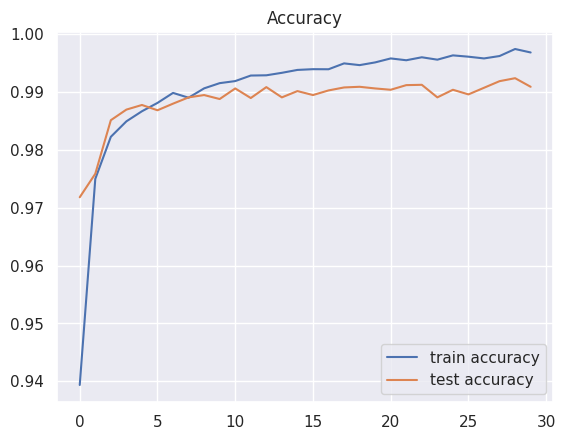

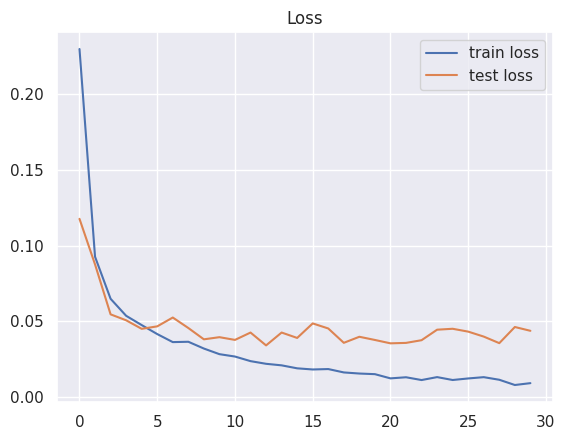

In [ ]:
# plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy') # label is actually 'validation accuracy'
plt.legend()
plt.show()

# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss') # label is actually 'validation accuracy'
plt.legend()
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

Training Accuracy: 99.62, Test Accuracy: 99.15
Training Loss: 1.46, Test Loss: 4.19


In [ ]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # Plotting
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, square=True, fmt='.20g', cmap='Greens')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

684/684 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step


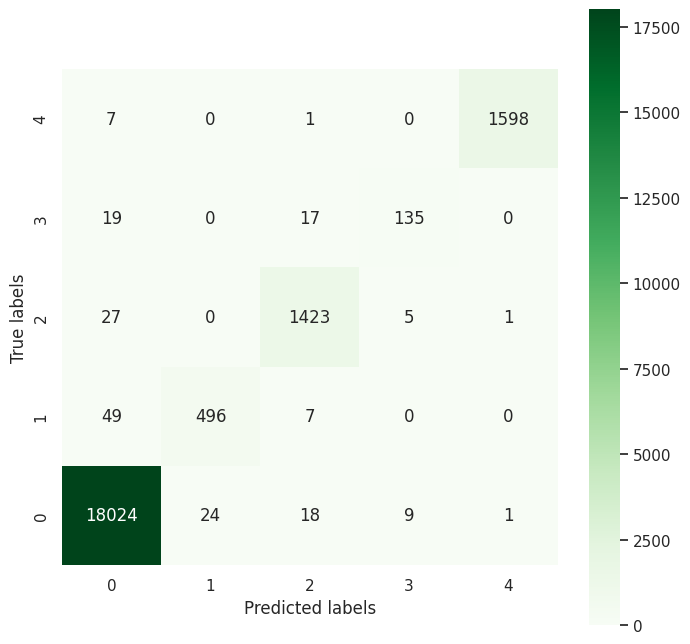

In [ ]:
# predict
Y_pred = np.argmax(model.predict(x_test), axis=-1)
# Y_pred = model.predict_classes(X_test)
# plot confusion matrix
plotHeatMap(y_test, Y_pred)

In [ ]:
# Per class accuracy printing function
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    '''
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy': (TP+TN)/(TP+FP+FN+TN)
             }'''

    report = {'Sensitivity (%)': TPR*100,
              'Specificity (%)': TNR*100,
              'F1 Score (%)': 2*100*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy (%)': (TP+TN)*100/(TP+FP+FN+TN)
             }
    return report

def multi_classification_report(y_test, y_pred, labels=None, encoded_labels=True, as_frame=False):
    """
    Args:
        y_test (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame

    Return:
        report (dict)
    """

    import numpy as np
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix

    conf_labels = None if encoded_labels else labels

    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels

    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)

    if as_frame:
        return pd.DataFrame(report)
    return report

In [ ]:
# Per class performance
labels = ['N', 'S', 'V', 'F', 'Q']
Y_pred = np.argmax(model.predict(x_test), axis=-1)
multi_classification_report(y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

684/684 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step


N          S          V          F          Q
Sensitivity (%)         99.712326  89.855072  97.733516  78.947368  99.501868
Specificity (%)         97.305152  99.887372  99.789267  99.935454  99.990126
F1 Score (%)            99.574609  92.537313  97.399042  84.375000  99.688085
Per Class Accuracy (%)  99.295549  99.634052  99.652349  99.771282  99.954256

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model_path = "CAT.keras"  # Path to the saved model
loaded_model = load_model('/content/drive/MyDrive/TinyML/'+model_path)

# Display information about the model
print("Model Summary:")
loaded_model.summary()

print("\nModel Config:")
print(loaded_model.get_config())

print("\nModel Layers:")
for i, layer in enumerate(loaded_model.layers):
    print(f"Layer {i + 1}: {layer.name}, Type: {layer.__class__.__name__}")


Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 300, 16)             │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 150, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 150, 32)             │          11,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 75, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 75, 64)              │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 38, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 38, 128)             │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 38, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 38, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 38, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2432)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         311,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,555,596 (5.93 MB)

 Trainable params: 777,797 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 777,799 (2.97 MB)


Model Config:
{'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 300, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 16, 'kernel_size': (21,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registere

In [ ]:
# Calculate model size
model_size = os.path.getsize('/content/drive/MyDrive/TinyML/'+model_path) / (1024 * 1024)  # Size in MB
print(f"\nModel File Size: {model_size:.2f} MB")
# Calculate model complexity (number of parameters)
trainable_params = sum([layer.count_params() for layer in loaded_model.layers if layer.trainable])
non_trainable_params = sum([layer.count_params() for layer in loaded_model.layers if not layer.trainable])
total_params = trainable_params + non_trainable_params

print(f"\nModel Complexity:")
print(f"  Trainable Parameters: {trainable_params:,}")
print(f"  Non-trainable Parameters: {non_trainable_params:,}")
print(f"  Total Parameters: {total_params:,}")


Model File Size: 8.96 MB

Model Complexity:
  Trainable Parameters: 777,797
  Non-trainable Parameters: 0
  Total Parameters: 777,797


QUANTISATION


In [ ]:
import os
import tensorflow as tf

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Use default optimization for size reduction
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Use TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TF ops
]

# Disable experimental lowering of tensor list operations
converter._experimental_lower_tensor_list_ops = False

# Enable resource variable handling
converter.experimental_enable_resource_variables = True

# Convert the model with quantization
tflite_model = converter.convert()

# Set a specific file path for saving the quantized model
model_file_name = os.path.join('/content/drive/MyDrive/TinyML/', 'cat_model_quantized.tflite')  # Replace '/path/to/directory' with your desired path

# Save the quantized model to the specified file path
with open(model_file_name, 'wb') as f:
    f.write(tflite_model)

# Print the full path of the saved model
model_file_path = os.path.abspath(model_file_name)
print(f"The quantized TFLite model is saved at: {model_file_path}")

# Use xxd to convert the quantized model to C++ source code for embedding into Arduino
!apt-get -qq install xxd
!xxd -i /content/drive/MyDrive/TinyML/cat_model_quantized.tflite > /content/drive/MyDrive/TinyML/cat_model_quantized.cpp
!cat /content/drive/MyDrive/TinyML/cat_model_quantized.cpp


Streaming output truncated to the last 5000 lines.
  0xf8, 0x45, 0xd8, 0x25, 0xc6, 0xe0, 0x04, 0xfa, 0x0b, 0x0a, 0xd4, 0x25,
  0xf8, 0xb0, 0x0b, 0x1a, 0xf6, 0xf9, 0xda, 0x2d, 0xef, 0x1c, 0xed, 0xc4,
  0xf2, 0x1d, 0x30, 0xe7, 0xda, 0x9d, 0xe3, 0x97, 0xf9, 0x22, 0x18, 0xe4,
  0xef, 0xc4, 0xc5, 0xff, 0x0c, 0xe1, 0xdc, 0x12, 0x02, 0xd3, 0xf9, 0xe8,
  0x11, 0xc1, 0xe9, 0xce, 0xed, 0x1f, 0x15, 0x01, 0xd4, 0x12, 0x44, 0xd9,
  0xe9, 0xf5, 0x07, 0xd7, 0xf7, 0x4b, 0xb9, 0x15, 0xd0, 0xe2, 0x14, 0x16,
  0x0e, 0x08, 0x03, 0x26, 0xfb, 0xd0, 0x0e, 0x21, 0xc8, 0xe1, 0xe5, 0x32,
  0x02, 0x14, 0xf3, 0xd0, 0x07, 0x17, 0x25, 0xde, 0xd4, 0x81, 0xe8, 0xa7,
  0xf1, 0x09, 0x1f, 0xd5, 0xfb, 0xbf, 0xbe, 0x0c, 0xf0, 0xc5, 0xdd, 0x0b,
  0x16, 0xc8, 0xfb, 0xdb, 0x2b, 0xa8, 0x00, 0xe3, 0xee, 0x20, 0x1f, 0x15,
  0xc2, 0x1c, 0x37, 0xfd, 0x05, 0xdf, 0x11, 0xf7, 0xd7, 0x47, 0xac, 0xe8,
  0xe3, 0xff, 0x0f, 0x17, 0xf6, 0x18, 0xff, 0x21, 0x0b, 0xf1, 0x08, 0x23,
  0xcc, 0xd4, 0x01, 0x1b, 0x16, 0x1a, 0x08, 0x0f, 0x1b, 0x0d,

In [ ]:
!ls -lh /content/drive/MyDrive/TinyML/cat_model_quantized.tflite


-rw------- 1 root root 814K Jan 19 14:55 /content/drive/MyDrive/TinyML/cat_model_quantized.tflite


In [ ]:
import os

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable support for TensorFlow ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Use TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TF ops
]

# Disable experimental lowering of tensor list operations
converter._experimental_lower_tensor_list_ops = False

# Enable resource variable handling
converter.experimental_enable_resource_variables = True

tflite_model = converter.convert()

# Set a specific file path for saving the model
model_file_name = os.path.join('/content/drive/MyDrive/TinyML/', 'cat_model.tflite')  # Replace '/path/to/directory' with your desired path

# Save the model to the specified file path
with open(model_file_name, 'wb') as f:
    f.write(tflite_model)

# Print the full path of the saved model
model_file_path = os.path.abspath(model_file_name)
print(f"The TFLite model is saved at: {model_file_path}")


Saved artifact at '/tmp/tmp1i9wu86p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136099312848144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099312848912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099312850448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099312848528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099312844880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099312850064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099312851600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099312849104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099312845072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099312849872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136099310299536: Ten

In [ ]:
!apt-get -qq install xxd
!xxd -i cat_model.tflite > cat_model.cpp
!cat cat_model.cpp

Streaming output truncated to the last 5000 lines.
  0x4c, 0x3d, 0x3b, 0x3d, 0x1f, 0x27, 0x8b, 0xbe, 0xc5, 0x2f, 0xd7, 0xbc,
  0x12, 0x0a, 0x42, 0x3d, 0x08, 0xc9, 0x92, 0xbd, 0xd5, 0xeb, 0x06, 0xbe,
  0xa7, 0xce, 0x64, 0xbe, 0xda, 0xe9, 0xe0, 0x3d, 0x3c, 0x7b, 0xa7, 0x3c,
  0xe0, 0x66, 0x85, 0xbe, 0x29, 0xf5, 0xe0, 0xbd, 0x63, 0x3c, 0x0c, 0xbe,
  0x6f, 0x79, 0xdc, 0xbd, 0x54, 0x0b, 0xf9, 0x3c, 0x5b, 0x47, 0x86, 0x3c,
  0x09, 0xa1, 0x73, 0xbe, 0xf5, 0x2d, 0xe9, 0xbd, 0xf6, 0x65, 0x22, 0x3e,
  0xc2, 0xe3, 0xff, 0xbc, 0x85, 0xdc, 0x80, 0xbe, 0x60, 0x01, 0xa6, 0xbd,
  0x77, 0x7c, 0x05, 0xbe, 0xfd, 0x8e, 0xaa, 0xbe, 0xc5, 0xb7, 0xde, 0xbd,
  0xd5, 0x09, 0x7b, 0x3d, 0x59, 0x01, 0xaa, 0x3d, 0xf9, 0x20, 0xed, 0xbd,
  0x83, 0x40, 0x3b, 0x3d, 0xaa, 0xc7, 0xfa, 0xbd, 0x14, 0x16, 0x6e, 0xbd,
  0xa6, 0x78, 0xf5, 0x3d, 0x17, 0x60, 0x5c, 0x3d, 0xef, 0x91, 0xf7, 0xbd,
  0xf9, 0x76, 0xfc, 0x3b, 0x7c, 0x64, 0xcc, 0x3d, 0x71, 0xf8, 0xa4, 0xbe,
  0x2e, 0xa8, 0x13, 0xbe, 0xfb, 0x5f, 0x95, 0xbe, 0x7f, 0xc8,

In [ ]:
!ls -lh cat_model.tflite



-rw-r--r-- 1 root root 3.0M Jan 19 14:40 cat_model.tflite
